# Topic Modeling Assessment - Due by 9/4/2020 - 4pm

For this assignment you will be working with a dataset of  quora questions (please download from eLearning) that have no labeled cateogry and attempt to find representtaive topics for the questions. Try different topic modeling appraoches discussed in the class. 

The choice of number of topics will depend on what number gives you meaningful topics. Please explain different topics that you have extracted.

In [1]:
import pandas as pd 

In [4]:
df = pd.read_csv('quora_questions.csv')

In [27]:
df.describe()

,Question
count,404289
unique,290456
top,How do I improve my English speaking?
freq,50


In [6]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/jj/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [10]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['what', 'why', 'where', 'who'])

In [15]:
# Import Dataset
print(df.Question.unique())
df.head()

['What is the step by step guide to invest in share market in india?'
 'What is the story of Kohinoor (Koh-i-Noor) Diamond?'
 'How can I increase the speed of my internet connection while using a VPN?'
 ... 'What is one coin?'
 'What is the approx annual cost of living while studying in UIC Chicago, for an Indian student?'
 'What is like to have sex with cousin?']


,Question
0,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,How can I increase the speed of my internet co...
3,Why am I mentally very lonely? How can I solve...
4,"Which one dissolve in water quikly sugar, salt..."


In [17]:
# Convert to list
data = df.Question.values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['What is the step by step guide to invest in share market in india?']


In [18]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india']]


In [19]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india']


In [20]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [22]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['step', 'step', 'guide', 'invest', 'share', 'market']]


In [23]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2)]]


In [24]:
id2word[0]

'guide'

In [25]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('guide', 1), ('invest', 1), ('market', 1), ('share', 1), ('step', 2)]]

In [28]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [29]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.099*"much" + 0.053*"country" + 0.034*"look" + 0.030*"black" + '
  '0.024*"real" + 0.022*"site" + 0.019*"keep" + 0.019*"exam" + 0.019*"true" + '
  '0.016*"next"'),
 (1,
  '0.253*"good" + 0.038*"go" + 0.037*"start" + 0.020*"website" + 0.020*"long" '
  '+ 0.017*"business" + 0.014*"fast" + 0.014*"engineering" + 0.014*"service" + '
  '0.013*"language"'),
 (2,
  '0.057*"people" + 0.039*"learn" + 0.037*"know" + 0.029*"take" + '
  '0.028*"think" + 0.018*"company" + 0.018*"phone" + 0.017*"come" + '
  '0.014*"need" + 0.013*"account"'),
 (3,
  '0.053*"year" + 0.039*"become" + 0.031*"compare" + 0.026*"be" + '
  '0.026*"improve" + 0.024*"woman" + 0.023*"old" + 0.023*"really" + '
  '0.023*"give" + 0.021*"change"'),
 (4,
  '0.083*"way" + 0.067*"life" + 0.057*"use" + 0.052*"find" + 0.036*"feel" + '
  '0.029*"bad" + 0.029*"number" + 0.025*"different" + 0.025*"man" + '
  '0.021*"create"'),
 (5,
  '0.051*"money" + 0.038*"many" + 0.037*"book" + 0.030*"online" + 0.029*"say" '
  '+ 0.024*"place" +

In [35]:
from gensim.test.utils import datapath

# Save model to disk.
temp_file = datapath("lda_model_10.csv")
lda_model.save(temp_file)

In [37]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.730391961910458

Coherence Score:  0.232521745801596


In [46]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [55]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=50, step=5)

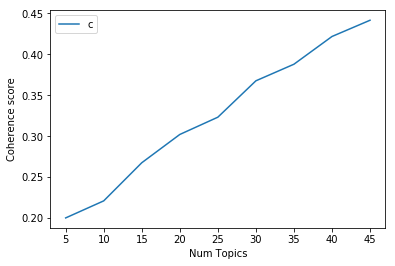

In [56]:
# Show graph
limit=50; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [57]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.2001
Num Topics = 10  has Coherence Value of 0.2209
Num Topics = 15  has Coherence Value of 0.2675
Num Topics = 20  has Coherence Value of 0.3021
Num Topics = 25  has Coherence Value of 0.3232
Num Topics = 30  has Coherence Value of 0.3677
Num Topics = 35  has Coherence Value of 0.3879
Num Topics = 40  has Coherence Value of 0.4218
Num Topics = 45  has Coherence Value of 0.4417


In [67]:
# Build LDA model
lda_model_1 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)

In [69]:
# Print the Keyword in the 10 topics
pprint(lda_model_1.print_topics())
doc_lda = lda_model_1[corpus]

[(0,
  '0.156*"difference" + 0.127*"go" + 0.086*"feel" + 0.079*"first" + '
  '0.077*"see" + 0.076*"love" + 0.062*"different" + 0.053*"account" + '
  '0.046*"fast" + 0.043*"help"'),
 (1,
  '0.553*"good" + 0.048*"say" + 0.046*"person" + 0.038*"stop" + 0.032*"create" '
  '+ 0.028*"service" + 0.025*"real" + 0.023*"employee" + 0.022*"government" + '
  '0.016*"view"'),
 (2,
  '0.271*"people" + 0.086*"company" + 0.071*"give" + 0.061*"free" + '
  '0.049*"call" + 0.036*"safe" + 0.033*"die" + 0.032*"reason" + 0.028*"mobile" '
  '+ 0.027*"turn"'),
 (3,
  '0.199*"make" + 0.105*"money" + 0.090*"think" + 0.083*"become" + '
  '0.065*"online" + 0.052*"improve" + 0.035*"human" + 0.029*"idea" + '
  '0.026*"visit" + 0.024*"food"'),
 (4,
  '0.223*"would" + 0.142*"learn" + 0.110*"start" + 0.081*"new" + 0.055*"place" '
  '+ 0.039*"answer" + 0.038*"language" + 0.031*"great" + 0.031*"course" + '
  '0.028*"water"'),
 (5,
  '0.185*"life" + 0.140*"thing" + 0.114*"book" + 0.111*"day" + 0.032*"state" + '
  '0.032*